In [1]:
# i tutaj zaczyna się przygoda!

In [2]:
## Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import pandas as pd
import io
#import itertools
import datetime

In [3]:
# collecting data

infections = pd.read_csv('pre11_2020_infected_data.txt', sep = "\t", encoding = 'ANSI')
deaths = pd.read_csv('pre11_2020_deaths_data.txt', sep = "\t", encoding = 'ANSI')

infections2 = pd.read_csv('post11_2020_infected_data.txt', sep = "\t", encoding = 'ANSI')
deaths2 = pd.read_csv('post11_2020_deaths_data.txt', sep = "\t", encoding = 'ANSI')

population = pd.read_csv('new_ludnosc2.txt', sep = '\t', encoding = 'utf-8')

In [4]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [5]:
def print_how_many(x, rows):
    pd.set_option('display.max_rows', rows)
    print(x)
    pd.reset_option('display.max_rows')

In [6]:
# editing and sorting dataframes

def edit_pop(x):
    x = x.replace("\t", "")
    x = x.replace(" ", "")
    x = x.replace("Woj.", "")
    return x

def edit_inf(x):
    x = x.replace("Powiat ", "")
    x = x.replace(" ", "")
    x = x.replace("st.", "")
    return x

population['new_district'] = population['district'].apply(edit_pop)
population['new_province'] = population['province'].apply(edit_pop)
population = population.drop(columns=['district'])
population = population.drop(columns=['province'])
population = population.rename(columns = {'new_district':'district'})
population = population.rename(columns = {'new_province':'province'})
population['district'] = population['district'].str.lower()
population['province'] = population['province'].str.lower()
#population = population.sort_values('district')

infections['date'] = pd.to_datetime(infections['date'], format = '%d.%m.%Y') 
infections['district'] = infections['district'].apply(edit_inf)
infections['province'] = infections['province'].apply(edit_inf)
infections['district'] = infections['district'].str.lower()
infections['province'] = infections['province'].str.lower()
infections = infections.sort_values(by=['district', 'date'])

infections2['date'] = pd.to_datetime(infections2['date'], format = '%d.%m.%Y') 
infections2['district'] = infections2['district'].apply(edit_inf)
infections2['province'] = infections2['province'].apply(edit_inf)
infections2['district'] = infections2['district'].str.lower()
infections2['province'] = infections2['province'].str.lower()
infections2 = infections2[infections2.district != 'sumazpowiatów']
infections2 = infections2.sort_values(by=['district', 'date'])

deaths['date'] = pd.to_datetime(deaths['date'], format = '%d.%m.%Y') 
deaths['district'] = deaths['district'].apply(edit_inf)
deaths['province'] = deaths['province'].apply(edit_inf)
deaths['district'] = deaths['district'].str.lower()
deaths['province'] = deaths['province'].str.lower()
deaths = deaths.sort_values(by=['district', 'date'])

deaths2['date'] = pd.to_datetime(deaths2['date'], format = '%d.%m.%Y') 
deaths2['district'] = deaths2['district'].apply(edit_inf)
deaths2['province'] = deaths2['province'].apply(edit_inf)
deaths2['district'] = deaths2['district'].str.lower()
deaths2['province'] = deaths2['province'].str.lower()
deaths2 = deaths2[deaths2.district != 'sumazpowiatów']
deaths2 = deaths2.sort_values(by=['district', 'date'])

In [7]:
print(infections)

            date            province        district  infected_total
8480  2020-03-04  kujawsko-pomorskie  aleksandrowski             0.0
8481  2020-03-05  kujawsko-pomorskie  aleksandrowski             0.0
8482  2020-03-06  kujawsko-pomorskie  aleksandrowski             0.0
8483  2020-03-07  kujawsko-pomorskie  aleksandrowski             0.0
8484  2020-03-08  kujawsko-pomorskie  aleksandrowski             0.0
...          ...                 ...             ...             ...
79760 2020-11-19             śląskie        żywiecki          4501.0
79761 2020-11-20             śląskie        żywiecki          4556.0
79762 2020-11-21             śląskie        żywiecki          4625.0
79763 2020-11-22             śląskie        żywiecki          4685.0
79764 2020-11-23             śląskie        żywiecki          4698.0

[104940 rows x 4 columns]


In [8]:
# which_district = "m.warszawa"
# fig, ax = plt.subplots()
# plt.plot_date(infections[infections.district == which_district]["date"], infections[infections.district == which_district]["infected_total"])
# plt.xlabel('Data')
# #plt.xticks([])
# plt.ylabel('Liczba zakażeń')
# every_nth = 3
# for n, label in enumerate(ax.xaxis.get_ticklabels()):
#     if n % every_nth != 0:
#         label.set_visible(False)
# plt.title("Warszawa")

In [9]:
# which_district = "m.warszawa"
# fig, ax = plt.subplots()
# plt.plot_date(deaths[deaths.district == which_district]["date"], deaths[deaths.district == which_district]["dead_total"])
# plt.xlabel('Data')
# plt.ylabel('Liczba śmierci')
# every_nth = 3
# for n, label in enumerate(ax.xaxis.get_ticklabels()):
#     if n % every_nth != 0:
#         label.set_visible(False)
# plt.title("Warszawa")

In [10]:
infections['population'] = 0
deaths['population'] = 0
infections2['population'] = 0
deaths2['population'] = 0

In [11]:
# dodawanie populacji do df: infections i deaths + przepisywanie ostatniej valid wartości
last_infections = []
last_deaths = []

for ind in population.index:
    inf_cond = (infections['district'] == population['district'][ind]) & (infections['province'] == population['province'][ind])
    death_cond = (deaths['district'] == population['district'][ind]) & (deaths['province'] == population['province'][ind])
    infections.loc[inf_cond, 'population'] = population['population'][ind]
    deaths.loc[death_cond, 'population'] = population['population'][ind]
    
    inf_last_valid_idx = infections.loc[inf_cond].apply(pd.Series.last_valid_index)[3]
    death_last_valid_idx = deaths.loc[death_cond].apply(pd.Series.last_valid_index)[3]
    
    last_infections.append(infections.loc[inf_cond, 'infected_total'].loc[inf_last_valid_idx])
    last_deaths.append(deaths.loc[death_cond, 'dead_total'].loc[death_last_valid_idx])
    
    infections.loc[inf_cond, 'new_infected'] = infections.loc[inf_cond, 'infected_total'].diff()
    deaths.loc[death_cond, 'new_dead'] = deaths.loc[death_cond, 'dead_total'].diff()
    
    

In [12]:
# #testowanko

# cond1 = (infections['district'] == population['district'][1]) & (infections['province'] == population['province'][1])
# cond2 = (infections['district'] == population['district'][2]) & (infections['province'] == population['province'][2])
# death_cond1 = (deaths['district'] == population['district'][1]) & (deaths['province'] == population['province'][1])
# death_cond2 = (deaths['district'] == population['district'][2]) & (deaths['province'] == population['province'][2])

# # print(infections.loc[cond1, 'infected_total'])
# print_full(infections.loc[cond1, 'infected_total'])

# #print_full(deaths.loc[death_cond1, 'dead_total'])
# #print_full(deaths.loc[death_cond1, 'dead_total'])

# # print(int(infections.loc[cond1, 'infected_total'].tail(1)))
# # print(float(deaths.loc[death_cond1, 'dead_total'].tail(1)))
# # print(deaths.loc[death_cond1, 'dead_total'].iloc[-1]) #ZARAZ SPRÓBUJĘ NA TO ZAMIENIĆ U GÓRY
# # print(infections.loc[cond1, 'infected_total'].iloc[-2])

# print(infections.loc[cond1].apply(pd.Series.last_valid_index))
# #print(deaths.loc[death_cond1].apply(pd.Series.last_valid_index))

# last_valid_idx = deaths.loc[death_cond1].apply(pd.Series.last_valid_index)[3]
# last_valid_idx_inf = infections.loc[cond1].apply(pd.Series.last_valid_index)[3]

# print(last_valid_idx_inf)
# print(infections.loc[cond1, 'infected_total'].loc[last_valid_idx_inf])
# #print(deaths.loc[death_cond1, 'dead_total'].loc[266])
# #print(deaths.loc[death_cond1, 'dead_total'].iloc[last_valid_idx+1])

# #print(deaths.loc[death_cond1, 'dead_total'].iloc[-1])

In [13]:
# print(last_infections)
# print(last_deaths)

In [14]:
# infections = infections.sort_values(by=['population', 'date'])
# print(infections)
print(infections.loc[infections['district'] == "aleksandrowski"])

           date            province        district  infected_total  \
8480 2020-03-04  kujawsko-pomorskie  aleksandrowski             0.0   
8481 2020-03-05  kujawsko-pomorskie  aleksandrowski             0.0   
8482 2020-03-06  kujawsko-pomorskie  aleksandrowski             0.0   
8483 2020-03-07  kujawsko-pomorskie  aleksandrowski             0.0   
8484 2020-03-08  kujawsko-pomorskie  aleksandrowski             0.0   
...         ...                 ...             ...             ...   
8740 2020-11-19  kujawsko-pomorskie  aleksandrowski          1722.0   
8741 2020-11-20  kujawsko-pomorskie  aleksandrowski          1773.0   
8742 2020-11-21  kujawsko-pomorskie  aleksandrowski          1849.0   
8743 2020-11-22  kujawsko-pomorskie  aleksandrowski          1876.0   
8744 2020-11-23  kujawsko-pomorskie  aleksandrowski          1900.0   

      population  new_infected  
8480       54891           NaN  
8481       54891           0.0  
8482       54891           0.0  
8483       5489

In [15]:
# tutaj probujemy zrobic cumsum poprawnie no i dodaje populację do dataframe'u jak wyżej

#infections2 = infections2.sort_values(by=['population', 'date'])
#deaths2 = deaths2.sort_values(by=['population', 'date'])

for ind in population.index:
    inf_cond = (infections2['district'] == population['district'][ind]) & (infections2['province'] == population['province'][ind])
    death_cond = (deaths2['district'] == population['district'][ind]) & (deaths2['province'] == population['province'][ind])
    
    infections2.loc[inf_cond, 'population'] = population['population'][ind]
    deaths2.loc[death_cond, 'population'] = population['population'][ind]
    
    infections2.loc[inf_cond, 'infected_total'] = infections2.loc[inf_cond, 'new_infected'].cumsum()
    deaths2.loc[death_cond, 'dead_total'] = deaths2.loc[death_cond, 'new_death'].cumsum()
    
    infections2.loc[inf_cond, 'infected_total'] = infections2.loc[inf_cond, 'infected_total'] + last_infections[ind]
    deaths2.loc[death_cond, 'dead_total'] = deaths2.loc[death_cond, 'dead_total'] + last_deaths[ind]

#infections2 = infections2.sort_values(by=['population', 'date'])
#infections2 = infections2.sort_values(by=['population'])
#deaths2 = deaths2.sort_values(by=['population', 'date'])
#deaths2 = deaths2.sort_values(by=['population'])


# print(infections2)
print(infections2.loc[infections2['date'] == "2020-11-24"])

             date             province        district  new_infected  \
14531  2020-11-24   kujawsko-pomorskie  aleksandrowski           8.0   
100314 2020-11-24            podlaskie     augustowski          12.0   
141755 2020-11-24  warmińsko-mazurskie     bartoszycki          30.0   
44083  2020-11-24              łódzkie    bełchatowski          16.0   
25581  2020-11-24            lubelskie         bialski          37.0   
...           ...                  ...             ...           ...   
42752  2020-11-24             lubuskie          żarski          23.0   
24255  2020-11-24   kujawsko-pomorskie         żniński          13.0   
83302  2020-11-24          mazowieckie      żuromiński           5.0   
83742  2020-11-24          mazowieckie     żyrardowski          16.0   
133776 2020-11-24              śląskie        żywiecki          13.0   

        population  infected_total  
14531        54891          1908.0  
100314       57651           875.0  
141755       56562      

In [16]:
# print_full(infections2.loc[infections2['district'] == "sejneński"])

In [17]:
#łączę dataframe'y
# infections = pd.concat([infections, infections2], verify_integrity=True)
# deaths = pd.concat([deaths, deaths2], verify_integrity=True)
# infections = pd.concat([infections, infections2], ignore_index=True)
# deaths = pd.concat([deaths, deaths2], ignore_index=True)
infections = pd.concat([infections, infections2]).reset_index(drop=True)
deaths = pd.concat([deaths, deaths2]).reset_index(drop=True)

In [18]:
# print(deaths)
# print(deaths.loc[deaths['district'] == "augustowski"])
# print(deaths.loc[deaths['district'] == "aleksandrowski"])
# print(infections.loc[infections['district'] == "dolnośląski"])

Text(0.5, 1.0, 'Warszawa')

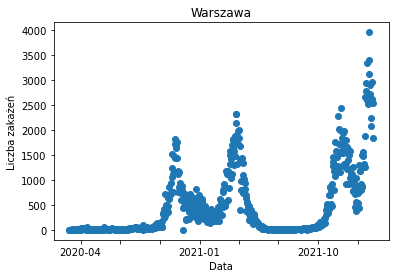

In [19]:
which_district = "m.warszawa"
fig, ax = plt.subplots()
plt.plot_date(infections[infections.district == which_district]["date"], infections[infections.district == which_district]["new_infected"])
plt.xlabel('Data')
#plt.xticks([])
plt.ylabel('Liczba zakażeń')
every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.title("Warszawa")

In [20]:
# tworzenie listy nr. indeksów dla pierwszego dnia pandemii dla danego powiatu dla zakażeń
infections['pandemic_day'] = 0
min_value_inf = 10  # dokładnie to liczymy od kiedy ta wartość zostanie przekroczona
first_day_inf = [] 
t = []
for ind in population.index:
    bool_infected = []
    cond = (infections['district'] == population['district'][ind]) & (infections['province'] == population['province'][ind])
    one_district = infections.loc[cond]
    if not one_district.empty:
        #print(population['district'][ind])
        t.append(population['district'][ind])
        one_district = one_district.sort_values(by=['date'])
        #print(one_district.loc[one_district['infected_total'] > min_value_inf])
        condition = one_district['infected_total'] > min_value_inf
        indices = one_district.index[condition]
        indices_list = indices.tolist()
        #print(indices_list)
        if indices_list:
            first_day_inf.append(indices_list[0])
        else:
            indices_list[0] = one_district.index.to_list()[-1]
            first_day_inf.append(indices_list[0])
        
        infections.loc[cond, 'pandemic_day'] = infections.index[cond] - indices_list[0]



#print(first_day_inf)
#print(len(first_day_inf))


In [21]:
# tworzenie listy nr. indeksów dla pierwszego dnia pandemii dla danego powiatu dla zgonów
deaths['pandemic_day'] = 0
min_value_deaths = 1 # dokładnie to liczymy od kiedy ta wartość zostanie przekroczona
first_day_deaths = []
t = []
for ind in population.index:
    bool_dead = []
    cond = (deaths['district'] == population['district'][ind]) & (deaths['province'] == population['province'][ind])
    one_district = deaths.loc[cond]
    if not one_district.empty:
        #print(population['district'][ind])
        t.append(population['district'][ind])
        one_district = one_district.sort_values(by=['date'])
        #print(one_district.loc[one_district['dead_total'] > min_value])
        condition = one_district['dead_total'] > min_value_deaths
        indices = one_district.index[condition]
        indices_list = indices.tolist()
        #print(indices_list)
        if indices_list:
            first_index = indices_list[0]
            first_day_deaths.append(first_index)
        else:
            first_index = one_district.index.to_list()[-1]
            first_day_deaths.append(first_index)

        deaths.loc[cond, 'pandemic_day'] = deaths.index[cond] - first_index

#print(first_day_deaths)
#print(len(first_day_deaths))


In [22]:
# dopasowanko prostej w skali log-log i wyplotowanie

#264 dni z danych
# do prezentacji 

def fit_n_plot_loglog(x, y, title, yscale_label):

    plt.plot(x, y, 'bo')
    plt.title(title)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel('Populacja')
    plt.ylabel(yscale_label)

    idx = np.isnan(y)
    xlog = np.log10(x)
    ylog = np.log10(y)

    a, b = np.polyfit(xlog[~idx],ylog[~idx],1)
    #print(a)
    #print(b)
    plt.plot(x, pow(x, a) * pow(10, b), color='red')
    return a, b

In [23]:
def fit_loglog(x, y):

    idx = np.isnan(y)
    xlog = np.log10(x)
    ylog = np.log10(y)

    a, b = np.polyfit(xlog[~idx],ylog[~idx],1)
    return a

Text(0.5, 1.0, '01.09.2020r.')

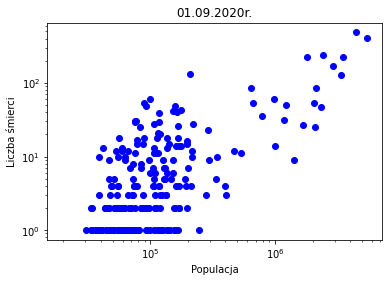

In [24]:
x = deaths.loc[deaths['date'] == '2020-09-01', 'population']
y = deaths.loc[deaths['date'] == '2020-09-01', 'dead_total']

plt.plot(x, y, 'bo')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Populacja')
plt.ylabel('Liczba śmierci')
plt.title("01.09.2020r.")

Text(0.5, 1.0, '01.09.2020r.')

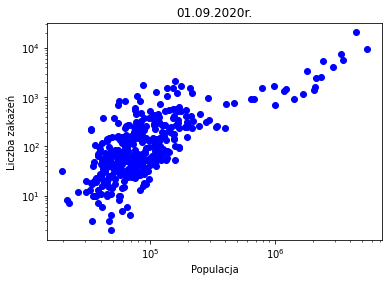

In [25]:
x = infections.loc[infections['date'] == '2020-09-01', 'population']
y = infections.loc[infections['date'] == '2020-09-01', 'infected_total']

plt.plot(x, y, 'bo')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Populacja')
plt.ylabel('Liczba zakażeń')
plt.title("01.09.2020r.")

Text(0, 0.5, 'Liczba zgonów')

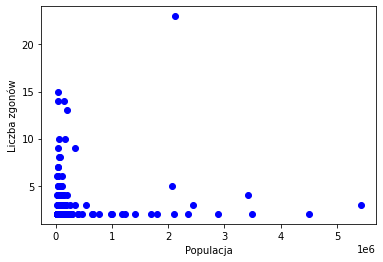

In [26]:
# Ile śmierci w pierwszy dzień pandemii
x = deaths.loc[deaths['pandemic_day'] == 0, 'population']
y = deaths.loc[deaths['pandemic_day'] == 0, 'dead_total']

plt.plot(x, y, 'bo')
plt.xlabel('Populacja')
plt.ylabel('Liczba zgonów')

#tutaj widać, że przez wybrakowane dane na początku, niektóre powiaty w pierwszy dzień mają dużo zakażonych 
#(zweryfikowałem, tak jest w danych)

In [27]:
#print_full(infections.loc[infections['district'] == "dolnośląskie"])
#print_full(infections.loc[infections['pandemic_day'] == 0])
#print_full(infections.loc[infections['district'] == "augustowski"])
print_full(infections.loc[infections['district'] == "dolnośląskie"])

             date      province      district  infected_total  population  \
9540   2020-03-04  dolnośląskie  dolnośląskie             0.0     2891321   
9541   2020-03-05  dolnośląskie  dolnośląskie             0.0     2891321   
9542   2020-03-06  dolnośląskie  dolnośląskie             1.0     2891321   
9543   2020-03-07  dolnośląskie  dolnośląskie             1.0     2891321   
9544   2020-03-08  dolnośląskie  dolnośląskie             2.0     2891321   
9545   2020-03-09  dolnośląskie  dolnośląskie             3.0     2891321   
9546   2020-03-10  dolnośląskie  dolnośląskie             4.0     2891321   
9547   2020-03-11  dolnośląskie  dolnośląskie             4.0     2891321   
9548   2020-03-12  dolnośląskie  dolnośląskie             7.0     2891321   
9549   2020-03-13  dolnośląskie  dolnośląskie             8.0     2891321   
9550   2020-03-14  dolnośląskie  dolnośląskie            13.0     2891321   
9551   2020-03-15  dolnośląskie  dolnośląskie            15.0     2891321   

Text(0, 0.5, 'Liczba zakażeń')

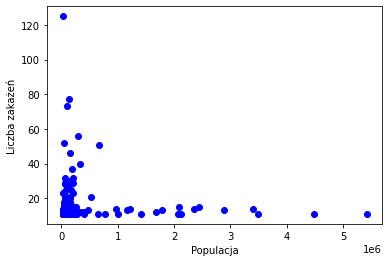

In [28]:
# Ile zakażonych w pierwszy dzień pandemii
x = infections.loc[infections['pandemic_day'] == 0, 'population']
y = infections.loc[infections['pandemic_day'] == 0, 'infected_total']

plt.plot(x, y, 'bo')
plt.xlabel('Populacja')
plt.ylabel('Liczba zakażeń')

#tutaj widać, że przez wybrakowane dane na początku, niektóre powiaty w pierwszy dzień mają dużo zakażonych 
#(zweryfikowałem, tak jest w danych)

(0.2715967133071475, 0.40629491891002784)

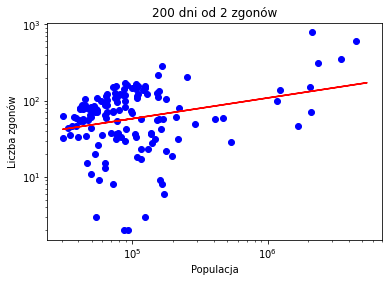

In [29]:
#264 dni z danych
# do prezentacji 
x = deaths.loc[deaths['pandemic_day'] == 200, 'population']
y = deaths.loc[deaths['pandemic_day'] == 200, 'dead_total']

fit_n_plot_loglog(x, y, "200 dni od 2 zgonów", "Liczba zgonów")


(0.6876476404886848, -0.6459288125864432)

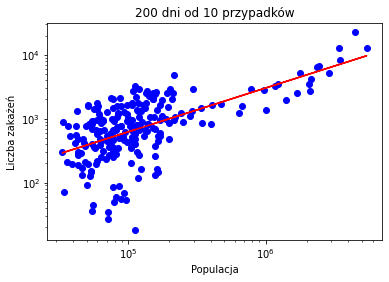

In [30]:
#264 dni z danych
# do prezentacji 
x = infections.loc[infections['pandemic_day'] == 200, 'population']
y = infections.loc[infections['pandemic_day'] == 200, 'infected_total']

fit_n_plot_loglog(x, y, "200 dni od 10 przypadków", "Liczba zakażeń")


250


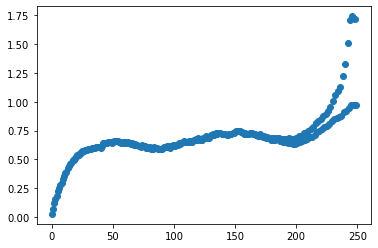

In [31]:
#
days_num = 250
wykladniki = []
for i in range(days_num):
    x = infections.loc[infections['pandemic_day'] == i, 'population']
    y = infections.loc[infections['pandemic_day'] == i, 'infected_total']
    a = fit_loglog(x, y)
    wykladniki.append(a)

print(len(wykladniki)) 
    
plt.scatter(range(days_num), wykladniki)

400


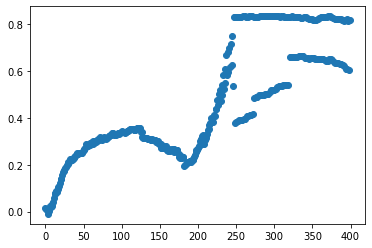

In [32]:
#
days_num = 400
wykladniki = []
for i in range(days_num):
    x = deaths.loc[deaths['pandemic_day'] == i, 'population']
    y = deaths.loc[deaths['pandemic_day'] == i, 'dead_total']
    a = fit_loglog(x, y)
    wykladniki.append(a)

print(len(wykladniki)) 
    
plt.scatter(range(days_num), wykladniki)

Text(0, 0.5, 'Liczba zgonów per capita')

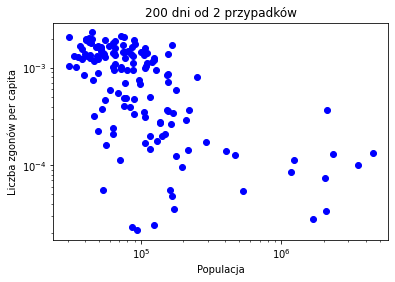

In [33]:
# do prezentacji 
x = deaths.loc[deaths['pandemic_day'] == 200, 'population']
y = deaths.loc[deaths['pandemic_day'] == 200, 'dead_total']

y = y / x
plt.plot(x, y, 'bo')
plt.title("200 dni od 2 przypadków")
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Populacja')
plt.ylabel('Liczba zgonów per capita')

Text(0, 0.5, 'Liczba zakażeń per capita')

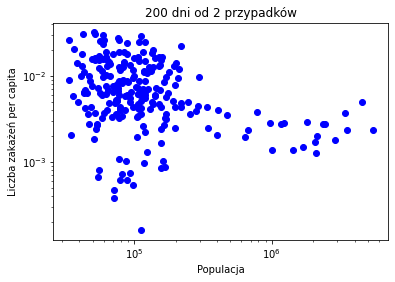

In [34]:
# do prezentacji 
x = infections.loc[infections['pandemic_day'] == 200, 'population']
y = infections.loc[infections['pandemic_day'] == 200, 'infected_total']

y = y / x
plt.plot(x, y, 'bo')
plt.title("200 dni od 2 przypadków")
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Populacja')
plt.ylabel('Liczba zakażeń per capita')

In [35]:
def compare(s, t):
    t = list(t)   # make a mutable copy
    try:
        for elem in s:
            t.remove(elem)
    except ValueError:
        return False
    return t

s = infections.loc[infections['date'] == '2020-08-25', 'district'].to_list()

print(compare(s, t))

#ok czyli jest git tutaj, wszystkie powiaty bierę pod uwagę

[]


In [36]:
#posumowac dane z powiatów do województw
# last_province_name = ""
# for ind in population.index:
#     suma = 0
#     one_province = infections.loc[(infections['province'] == population['province'][ind]) & (infections['date'] == '2020-08-25')]
#     if not one_province.empty:
#         if not (one_province['province'].iloc[0] == last_province_name):
#             last_province_name = one_province['province'].iloc[0]
#             #print(one_province)
#             suma += one_province['population'].sum()
#             whole_province = one_province.loc[one_province['province'] == one_province['district']]
#             suma /= 2
#             print(str(one_province['province'].iloc[0]))
#             print("Z danych: "+ str(whole_province['population'].iloc[0]))
#             print("Posumowane: " + str(suma))
#             print()
        

In [37]:
# Okej, obczaiłem. Jest rozbieżność pomiędzy danymi dot. zakażeń w tym pliku excelowskim, a tymi w tekstowym. 
# W tekstowym, skąd brałem dane nie ma wszystkich powiatów, np. w województwie kujawsko-pomorskim jest tylko powiat aleksanrowsk
# 